Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due on Friday, November 21, 2014.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [1]:
# Write your work here
import pandas as pd
titanic = pd.read_excel('./titanic.xls')


### We're going to use the first letter of the cabin to make a class

In [3]:
titanic['cabin_class'] = titanic.cabin.apply(lambda x: x[0] if (not pd.isnull(x)) else '0' )

### Binarize the gender variable

In [4]:
titanic.sex = titanic.sex.replace({'female':0, 'male':1})

### Take the destination variable and split it into people going to the states and people from abroad

In [5]:
def dest_in_US(dest):
    states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
    for state in states:
        if dest.count(state) > 0:
            return 1;
    return 0;

In [6]:
titanic['home_dest_in_US']=titanic['home.dest'].apply(lambda x: dest_in_US(x) if (not pd.isnull(x)) else 'NaN')

In [7]:
titanic['embarked']=titanic.embarked.replace({'S':0, 'C':1, 'Q':2})

### We'll choose our set of predictors

In [8]:
X0=titanic[['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'boat', 'cabin_class', 'home_dest_in_US']]

### Let's center the fare variable

In [11]:
X0.loc[:,'fare'] = (X0['fare'] - X0['fare'].mean())/X0['fare'].std()

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### This is the outcome variable

In [13]:
Y=titanic.survived

### Let's change the life boat variable to a set of dummy categorical predictors

In [14]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [15]:
lb.fit(X0.boat.unique().astype(str))

LabelBinarizer(neg_label=0, pos_label=1)

#### These are all the possible values for life boat

In [16]:
X0.boat.unique().astype(str)

array(['2', '11', 'nan', '3', '10', 'D', '4', '9', '6', 'B', '8', 'A', '5',
       '7', 'C', '14', '2', '5 9', '13', '1', '15', '5 7', '8 10', '12',
       '16', '13 15 B', 'C D', '15 16', '13 15'], 
      dtype='|S7')

In [17]:
X0.boat.unique().size

29

#### Let's do some sanity checks ... 

In [18]:
lb.transform(X0.boat.values)[pd.isnull(X0.boat.values),:]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
lifeBoat_expanded = pd.DataFrame(lb.transform(X0.boat.values)[:,0:27], columns=['LB_' + x for x in lb.classes_[:-1]])

### Let's binarize the cabin classs variable...

In [20]:
cabinClassBinarizer = preprocessing.LabelBinarizer()
cabinClassBinarizer.fit(X0.cabin_class.unique().astype(str))

LabelBinarizer(neg_label=0, pos_label=1)

In [21]:
cabinClassExpanded = pd.DataFrame(cabinClassBinarizer.transform(X0.cabin_class.values), columns=['CC_' + x for x in cabinClassBinarizer.classes_])

In [23]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
median_imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
mode_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)

In [24]:
mode_imputer.fit_transform(X0.home_dest_in_US.values).T

array([[ 1.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])

In [25]:
X0=X0[['pclass', 'sex', 'sibsp', 'parch', 'fare', 'embarked', 'home_dest_in_US']]

In [26]:
X0=pd.concat([X0, lifeBoat_expanded, cabinClassExpanded], axis=1)

In [27]:
X0.home_dest_in_US = mode_imputer.fit_transform(X0.home_dest_in_US).T

In [28]:
X0.fare = mean_imputer.fit_transform(X0.fare).T

In [29]:
X0.embarked = mode_imputer.fit_transform(X0.embarked).T

Sanity check

In [30]:
pd.isnull(X0).any()

pclass             False
sex                False
sibsp              False
parch              False
fare               False
embarked           False
home_dest_in_US    False
LB_1               False
LB_10              False
LB_11              False
LB_12              False
LB_13              False
LB_13 15           False
LB_13 15 B         False
LB_14              False
LB_15              False
LB_15 16           False
LB_16              False
LB_2               False
LB_3               False
LB_4               False
LB_5               False
LB_5 7             False
LB_5 9             False
LB_6               False
LB_7               False
LB_8               False
LB_8 10            False
LB_9               False
LB_A               False
LB_B               False
LB_C               False
LB_C D             False
LB_D               False
CC_0               False
CC_A               False
CC_B               False
CC_C               False
CC_D               False
CC_E               False


In [32]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X0, Y)

In [33]:
from sklearn.linear_model import LogisticRegression

lrmod = LogisticRegression(C=1000)
lrmod.fit(X_train, y_train)

pred_train = lrmod.predict(X_train)
pred_test = lrmod.predict(X_test)

In [34]:
pd.crosstab(y_train, pred_train, 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,582,6
1,19,374


In [35]:
pd.crosstab(y_test, pred_test, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,218,3
1,4,103


In [36]:
import numpy as np
n = 1000
boot_samples = np.empty((n, len(lrmod.coef_[0])))

for i in np.arange(n):
    boot_ind = np.random.randint(0, len(X0), len(X0))
    y_i, X_i = Y.values[boot_ind], X0.values[boot_ind]
    
    lrmod_i = LogisticRegression(C=1000)
    lrmod_i.fit(X_i, y_i)

    boot_samples[i] = lrmod_i.coef_[0]

In [37]:
boot_samples.sort(axis=0)

In [38]:
boot_se = boot_samples[[25, 975], :].T

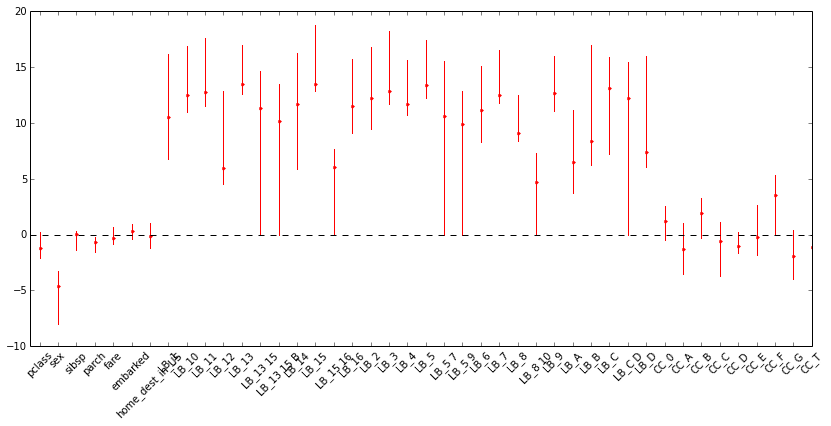

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

coefs = lrmod.coef_[0]
plt.figure(figsize=(14,6))
plt.plot(coefs, 'r.')
for i in range(len(coefs)):
    plt.errorbar(x=[i,i], y=boot_se[i], color='red')
plt.xlim(-0.5, 20)
plt.xticks(range(len(coefs)), X0.columns.values, rotation=45)
plt.axhline(0, color='k', linestyle='--')

### Now do it with SVM

In [40]:
from sklearn import svm

In [41]:
svc = svm.SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [42]:
svc.score(X_test, y_test)

0.97560975609756095

## Question 2

The data in `prostate.data.txt` come from a study by Stamey et al. (1989), which examined the correlation between the level of prostate-specific antigen (`lpsa`) and a number of clinical measures in men who were about to receive a radical prostatectomy. The variables are log cancer volume (`lcavol`), log prostate weight (`lweight`), age, log of the amount of benign prostatic hyperplasia (`lbph`), seminal vesicle invasion (`svi`), log of capsular penetration (`lcp`), Gleason score (`gleason`), and percent of Gleason scores 4 or 5 (`pgg45`). 

1. Select (your choice) five competing 3-variable linear regression models, and compare them using AIC, five-fold and ten-fold cross-validation. Discuss the results.

2. An alternative method for model assessment is to fit the models on a set of bootstrap samples, and then keep track of how well it predicts the original training set. If $\hat{f}^b(x_i)$ is the predicted value at $x_i$, from the model fitted to the bth bootstrap dataset, such an estimate is:
$$\frac{1}{B} \frac{1}{N} \sum_{b=1}^B \sum_{i=1}^N L(y_i,\hat{f}^b(x_i)) $$
However, because the bootstrap samples tend to contain many observations in common among the set of bootstrap samples, this estimate will tend to underestimate the true error rate. The so-called .632 estimator aleviates this bias by returning a weighted average of the training error (average loss over the training sample) and the leave-one-out (LOO) bootstrap error:
$$\hat{err}^{(.632)} = 0.368 \, \bar{err} + 0.632 \, \hat{err}^{(1)}$$
where:
$$\bar{err} = \frac{1}{N}\sum_{i=1}^N L(y_i, \hat{f}(x_i)) $$
Repeat the assesment from part (1) using the .632 estimator, and compare the result to the other approaches.

In [43]:
import pandas as pd
import numpy as np

prostate = pd.read_table("./prostate.data.txt", sep='\s+')

In [44]:
Y = prostate.lpsa
model1 = prostate[['lcavol', 'lweight', 'age']]
model2 = prostate[['lcavol', 'lbph', 'svi']]
model3 = prostate[['lweight', 'lcp', 'gleason']]
model4 = prostate[['svi', 'lcp', 'pgg45']]
model5 = prostate[['age', 'svi', 'pgg45']]

In [45]:
models = [model1, model2, model3, model4, model5]

In [46]:
from sklearn.linear_model import LinearRegression

lreg1 = LinearRegression()


In [47]:
from sklearn.cross_validation import cross_val_score

# we need to take the negative of cross_val_score because 
# cross_val_score returns the negative of mean_squared_error
five_fold_CV_errors = [-cross_val_score(lreg1, model, Y, cv=5, scoring='mean_squared_error') for model in models]
ten_fold_CV_errors = [-cross_val_score(lreg1, model, Y, cv=10, scoring='mean_squared_error') for model in models]

def calc_AIC_for_linear_model(model, X, Y):
    model.fit(X,Y)
    rss = np.sum([x**2 for x in model.predict(X) - Y])
    n = len(Y)
    k = X.shape[1]
    aic = n * np.log(float(rss)/n) + 2*k
    return aic
    
aic_errors = [calc_AIC_for_linear_model(lreg1, model, Y) for model in models]


In [48]:
MSE_mean = pd.DataFrame({'5_Fold':np.mean(five_fold_CV_errors,axis=1), '10_Fold':np.mean(ten_fold_CV_errors,axis=1)}, index=pd.Index([1, 2,3, 4, 5], name='Model'))
MSE_error = pd.DataFrame({'5_Fold':np.std(five_fold_CV_errors,axis=1), '10_Fold':np.std(ten_fold_CV_errors,axis=1)}, index=pd.Index([1, 2,3, 4, 5], name='Model'))

C:\Anaconda\lib\site-packages\matplotlib\collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


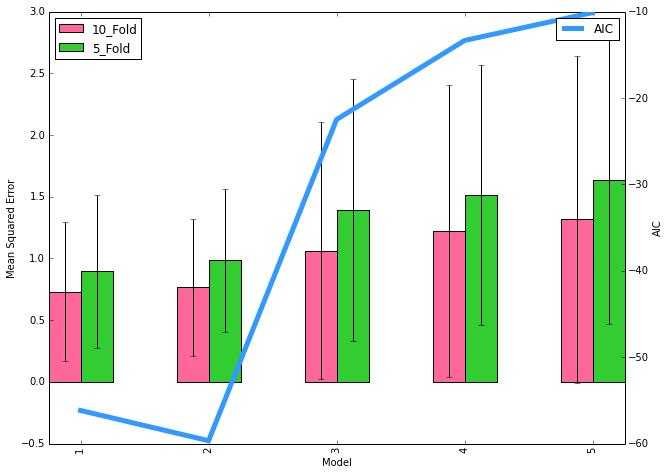

In [50]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0, 0, 1, 1]) # main axes
ax=MSE_mean.plot(yerr = MSE_error, kind='bar', ax=axes, color=('#FF6699', '#33CC33'))
ax.set_ylabel('Mean Squared Error')
ax2 = ax.twinx()
ax2.plot([0,1,2,3,4], aic_errors, color='#3399FF', linewidth=5)
ax2.set_ylabel('AIC')
plt.legend(['AIC'])

### Part 2)

In [51]:
from sklearn.metrics import mean_squared_error

def boot_sampled_error(estimator,X,Y):
    nBootTrials = 1000
    nBootSamples = len(Y)
    mse_sum = 0
    for i in np.arange(nBootTrials):
        boot_ind = np.random.randint(0, high=len(Y), size=nBootSamples)
        Y_i, X_i = Y.iloc[boot_ind], X.iloc[boot_ind]
        estimator.fit(X_i, Y_i)
        mse = mean_squared_error(Y, estimator.predict(X))
        mse_sum += mse
    return mse_sum / nBootTrials

In [52]:
print("Model 1 error: {0}".format(boot_sampled_error(lreg1, models[0], Y)))
print("Model 2 error: {0}".format(boot_sampled_error(lreg1, models[1], Y)))
print("Model 3 error: {0}".format(boot_sampled_error(lreg1, models[2], Y)))
print("Model 4 error: {0}".format(boot_sampled_error(lreg1, models[3], Y)))
print("Model 5 error: {0}".format(boot_sampled_error(lreg1, models[4], Y)))

Model 1 error: 0.550061566365
Model 2 error: 0.531092997681
Model 3 error: 0.778966057238
Model 4 error: 0.853734305136
Model 5 error: 0.888176968723


### Part 2B)

In [53]:
from sklearn.cross_validation import LeaveOneOut

def calc_632_estimator(estimator, X, Y):
    nBootTrials = 1000
    N = len(Y)
    nBootSamples = N

    # calculate err_bar
    estimator.fit(X, Y)
    training_error = np.sum((estimator.predict(X) - Y)**2) / N

    # calculate err_hat
    boot_ind = np.zeros((nBootTrials, nBootSamples), dtype=np.int32)
    for i in np.arange(nBootTrials):
        boot_ind[i,:] = np.random.randint(0, high=len(Y), size=nBootSamples)

    boot_slices_without_i =  [[i not in boot_slice for boot_slice in boot_ind] for i in np.arange(N)]

    LOO_bootstrap_error = 0
    for i in np.arange(N):
        # for each i collect the bootstrap samples that dont contain i
        C_i = np.where(boot_slices_without_i[i])
        n_C_i = C_i[0].size
        sse = 0
        for indicies in boot_ind[C_i]:
            Y_i, X_i = Y.iloc[indicies], X.iloc[indicies]
            estimator.fit(X_i, Y_i)

            # the pandas DataFrame is indexed starting from 1, not 0
            sse += (estimator.predict(X.iloc[i]) - Y.iloc[i])**2
        if n_C_i > 0:
            LOO_bootstrap_error += sse / n_C_i
    LOO_bootstrap_error /= N
    return 0.368 * training_error + .632 * LOO_bootstrap_error

In [54]:
print("Model 1 error: {0}".format(calc_632_estimator(lreg1, models[0], Y)))
print("Model 2 error: {0}".format(calc_632_estimator(lreg1, models[1], Y)))
print("Model 3 error: {0}".format(calc_632_estimator(lreg1, models[2], Y)))
print("Model 4 error: {0}".format(calc_632_estimator(lreg1, models[3], Y)))
print("Model 5 error: {0}".format(calc_632_estimator(lreg1, models[4], Y)))

Model 1 error: 0.57304692286
Model 2 error: 0.553709277228
Model 3 error: 0.809047430242
Model 4 error: 0.883349459816
Model 5 error: 0.92553135119


## Question 3

Fit a series of random-forest classifiers to the very low birthweight infant data (`vlbw.csv`), to explore the sensitivity to the parameter `m`, the number of variables considered for splitting at each step. Plot both the out-of-bag error as well as the test error against a suitably-chosen range of values for `m`.

In [2]:
# Write your work here
import pandas as pd
import numpy as np

vlbw = pd.read_csv("./vlbw.csv", index_col=0)


In [3]:
vlbw.race = vlbw.race.replace({'white':1, 'black':0, 'native American':0, 'oriental':0})
vlbw.inout = vlbw.inout.replace({'born at Duke':0, 'transported':1})
vlbw.delivery = vlbw.delivery.replace({'vaginal':0, 'abdominal':1})
vlbw.pvh = vlbw.pvh.replace({'absent':0, 'possible':1, 'definite':1})
vlbw.ipe = vlbw.ipe.replace({'absent':0, 'possible':1, 'definite':1})
vlbw.sex = vlbw.sex.replace({'male':0, 'female':1})

In [4]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=1)
median_imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
mode_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=1)

vlbw.birth = mean_imputer.fit_transform(vlbw.birth).T
vlbw.exit = mean_imputer.fit_transform(vlbw.exit).T
vlbw.hospstay = mean_imputer.fit_transform(vlbw.hospstay).T
vlbw.lowph = mean_imputer.fit_transform(vlbw.lowph).T
vlbw.pltct = mean_imputer.fit_transform(vlbw.pltct).T
vlbw.bwt = mean_imputer.fit_transform(vlbw.bwt).T
vlbw.gest = mean_imputer.fit_transform(vlbw.gest).T
vlbw.inout = mode_imputer.fit_transform(vlbw.inout).T
vlbw.race = mode_imputer.fit_transform(vlbw.race).T
vlbw.twn = mode_imputer.fit_transform(vlbw.twn).T
vlbw.lol[pd.isnull(vlbw.lol)] = np.median(vlbw.lol[~pd.isnull(vlbw.lol)]) 
vlbw.magsulf = mode_imputer.fit_transform(vlbw.magsulf).T
vlbw.meth = mode_imputer.fit_transform(vlbw.meth).T
vlbw.toc = mode_imputer.fit_transform(vlbw.toc).T
vlbw.delivery = mode_imputer.fit_transform(vlbw.delivery).T
vlbw.apg1[pd.isnull(vlbw.apg1)] =np.median(vlbw.lol[~pd.isnull(vlbw.apg1)]) # median_imputer.fit_transform(vlbw.apg1).T
vlbw.vent = mode_imputer.fit_transform(vlbw.vent).T
vlbw.pneumo = mode_imputer.fit_transform(vlbw.pneumo).T
vlbw.pda = mode_imputer.fit_transform(vlbw.pda).T
vlbw.cld = mode_imputer.fit_transform(vlbw.cld).T
vlbw.pvh = mode_imputer.fit_transform(vlbw.pvh).T
vlbw.ipe = mode_imputer.fit_transform(vlbw.ipe).T
vlbw.year = mean_imputer.fit_transform(vlbw.year).T
vlbw.sex = mode_imputer.fit_transform(vlbw.sex).T

# let's get rid of the observations where IVH, our response variable
# is NaN
vlbw = vlbw.dropna()
# Extract response variable
Y = vlbw.ivh.replace({'absent':0, 'possible':1, 'definite':1})

# make our predictor variables
X = vlbw[['birth', 'exit', 'hospstay', 'lowph', 'pltct', 'bwt', 'gest', 'year']]
X = (X - X.mean(axis=0)) / X.std(axis=0)
X=pd.concat([X, vlbw[['inout', 'race', 'twn','lol', 'magsulf', 
                        'meth', 'toc', 'delivery', 'apg1', 'vent',
                        'pneumo', 'pda', 'cld', 'pvh', 'sex']] ], axis=1)

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(
        X, Y, test_size=0.4, random_state=0)



In [6]:
accuracy_scores = np.zeros([9,])
for i in np.arange(1, 10, 1):
    rf = RandomForestClassifier(max_features=float(i)/10, oob_score=True)
    rf.fit(X_train, Y_train)
    accuracy_scores[i-1] = rf.score(X_test, Y_test)
    #preds = rf.predict(X_test)
    #pd.crosstab(Y_test, preds, rownames=['actual'], 
#                 colnames=['prediction'])

C:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:397: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [7]:
oob_scores = np.zeros([9,])
for i in np.arange(1, 10, 1):
    rf = RandomForestClassifier(max_features=float(i)/10, oob_score=True)
    rf.fit(X_train, Y_train)
    # accuracy_scores[i-1] = rf.score(X_test, Y_test)
    preds = rf.predict(X_test)
    oob_scores[i-1] = rf.oob_score_

In [8]:
oob_scores

array([ 0.81329114,  0.83544304,  0.80696203,  0.81012658,  0.82594937,
        0.85126582,  0.80696203,  0.78481013,  0.78481013])

In [9]:
accuracy_scores

array([ 0.87677725,  0.86729858,  0.87203791,  0.85781991,  0.8436019 ,
        0.84834123,  0.83886256,  0.82938389,  0.83412322])

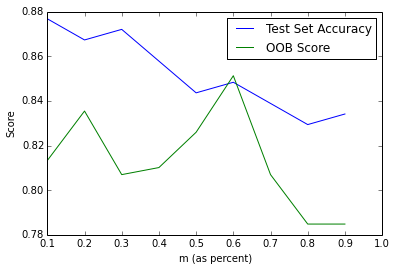

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.linspace(.1, 1, 10)[0:-1], accuracy_scores)
ax.plot(np.linspace(.1, 1, 10)[0:-1], oob_scores)
ax.set_ylabel('Score')
ax.set_xlabel('m (as percent)')
plt.legend(['Test Set Accuracy', 'OOB Score'])

## Bonus: Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the very low birthweight infant data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

In [ ]:
# Write your work here